In [25]:
# STEP 1: Initial setup and imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Button, HBox, VBox, Output
import ipywidgets as widgets

# Set the working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')

# Add scripts directory to path
sys.path.append('scripts')

# Import TCX parser (force fresh import)
import importlib
if 'parse_tcx' in sys.modules:
    importlib.reload(sys.modules['parse_tcx'])
from parse_tcx import parse_tcx_to_df

# Load the data
print("Loading User 56 TCX data...")
try:
    df, session_total_sec, sessions_avg_hr, session_max_hr, calories_burned = parse_tcx_to_df('data/56-d.tcx')
    session_duration_min = session_total_sec / 60
    print(f"Data loaded successfully: {len(df)} data points over {session_duration_min:.2f} minutes")
    print(f"Average HR: {sessions_avg_hr:.1f} bpm, Maximum HR: {session_max_hr} bpm, Calories: {calories_burned}")
except Exception as e:
    print(f"Error loading data: {e}")
    
# Load the background image
try:
    img = mpimg.imread('charts_cropped/user_56.png')
    print("Background image loaded successfully")
except Exception as e:
    print(f"Error loading background image: {e}")

# Create output directories for plots
plots_dir = f'output/plots/user_56'
os.makedirs(plots_dir, exist_ok=True)
print(f"Created plots directory: {plots_dir}")

Loading User 56 TCX data...
Data loaded successfully: 239 data points over 50.03 minutes
Average HR: 142.3 bpm, Maximum HR: 185 bpm, Calories: 445
Background image loaded successfully
Created plots directory: output/plots/user_56


In [26]:
# Load user metadata
user_id = 56

try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == user_id]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {user_id}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        age = gender = height_cm = weight_kg = champ_number = None
        print(f"No metadata found for user {user_id}")
except Exception as e:
    age = gender = height_cm = weight_kg = champ_number = None
    print(f"Error loading metadata: {e}")

Loaded metadata for user 56: age=None, gender= , height=Nonecm, weight=Nonekg, champ=5


In [27]:
# Initialize global alignment parameters
current_x_offset = -0.8
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6

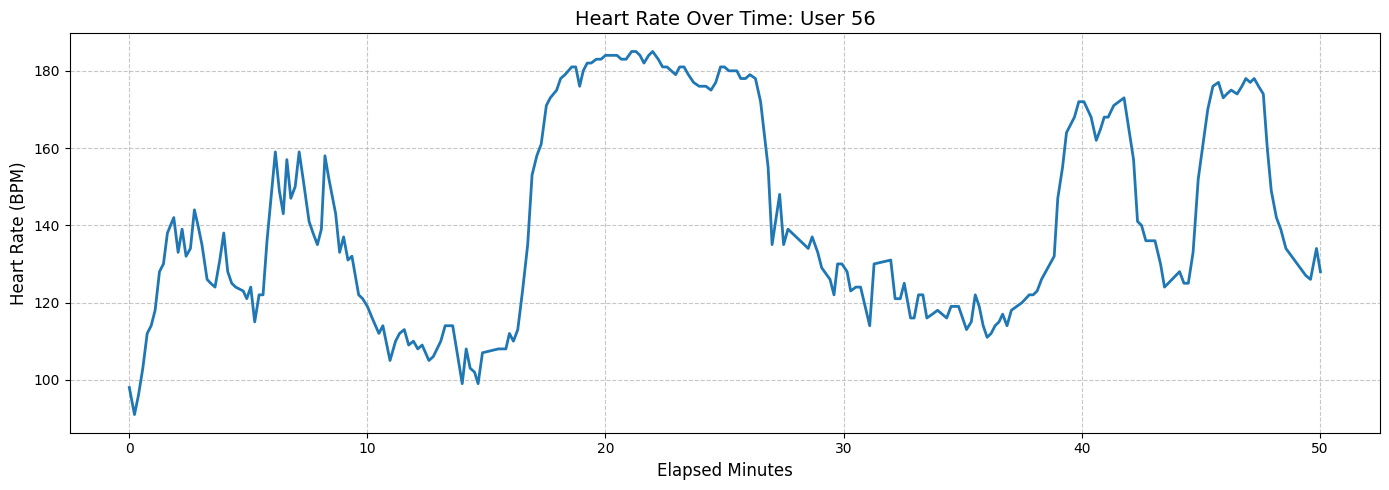

Maximum Heart Rate Details:
                    timestamp  heart_rate                start_time  \
107 2025-04-06 12:52:14+00:00         185 2025-04-06 12:31:08+00:00   
108 2025-04-06 12:52:25+00:00         185 2025-04-06 12:31:08+00:00   
112 2025-04-06 12:53:07+00:00         185 2025-04-06 12:31:08+00:00   

     elapsed_min  
107    21.100000  
108    21.283333  
112    21.983333  


In [28]:
# STEP 2: Visualize the heart rate data
plt.figure(figsize=(14,5))
plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title('Heart Rate Over Time: User 56', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{plots_dir}/heart_rate_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Show max heart rate point
max_hr_row = df[df['heart_rate'] == df['heart_rate'].max()]
print("Maximum Heart Rate Details:")
print(max_hr_row)

In [40]:
# STEP 3: Align heart rate data with Garmin graph
def update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    
    fig, ax = plt.subplots(figsize=(14,5))
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'Alignment: x_offset={x_offset}, x_scale={x_scale}', fontsize=12)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{plots_dir}/aligned_hr_data.png', dpi=300, bbox_inches='tight')
    plt.show()

# Interactive alignment tool
slider_layout = Layout(width='500px')
interact(update_alignment,
         x_offset=FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=slider_layout),
         x_scale=FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=slider_layout),
         y_min=IntSlider(min=0, max=100, step=5, value=90, description='Y Min:', layout=slider_layout),
         y_max=IntSlider(min=150, max=250, step=5, value=190, description='Y Max:', layout=slider_layout),
         alpha=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=slider_layout));

interactive(children=(FloatSlider(value=-0.8, description='X Offset:', layout=Layout(width='500px'), max=5.0, …

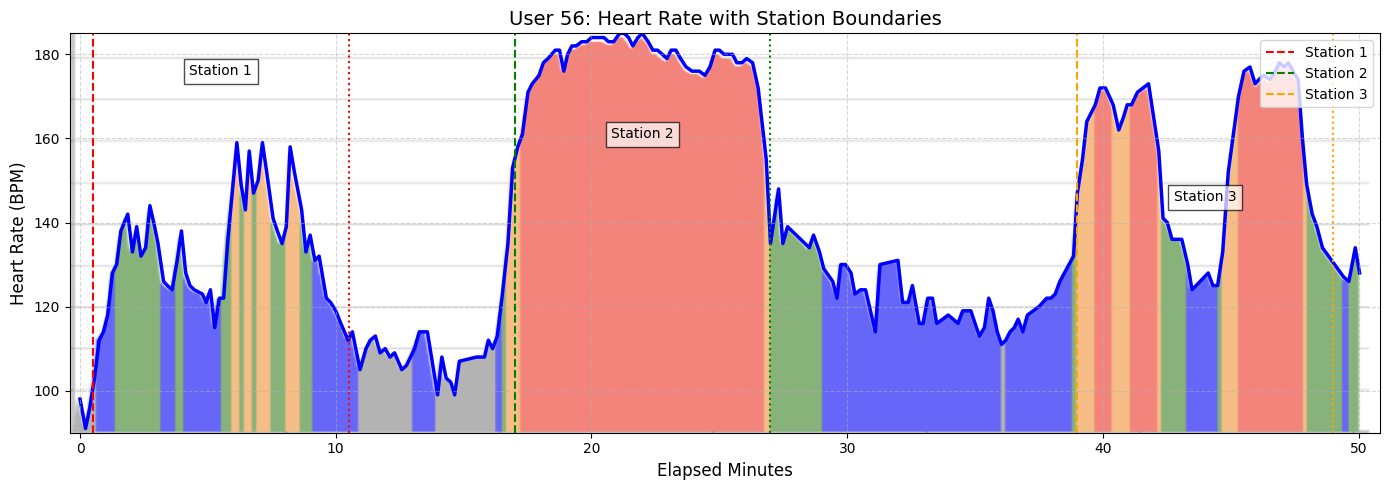

In [41]:
# STEP 4: Define station cutoffs and visualization function

# Define initial station cutoffs (start, end) for 3 stations
cutoffs = [(0.5, 10.5), (17, 27), (39, 49)]

def visualize_with_stations(cutoffs=None, x_offset=None, x_scale=None, y_min=None, y_max=None, alpha=None):
    # Use stored alignment parameters if not specified
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    x_offset = current_x_offset if x_offset is None else x_offset
    x_scale = current_x_scale if x_scale is None else x_scale
    y_min = current_y_min if y_min is None else y_min
    y_max = current_y_max if y_max is None else y_max
    alpha = current_alpha if alpha is None else alpha
    
    # Use provided cutoffs or global cutoffs
    if cutoffs is None:
        cutoffs = globals()['cutoffs']
        
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Calculate extent
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    # Display background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    # Plot HR data
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    # Add vertical lines for station boundaries
    colors = ['red', 'green', 'orange']
    for i, (start, end) in enumerate(cutoffs):
        ax.axvline(x=start, color=colors[i % len(colors)], linestyle='--', 
                   label=f'Station {i+1} Start')
        ax.axvline(x=end, color=colors[i % len(colors)], linestyle=':',
                   label=f'Station {i+1} End')
        
        # Add station labels
        y_pos = y_max - 10 - (i * 15)
        ax.text((start + end)/2, y_pos, f'Station {i+1}', 
                horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'User 56: Heart Rate with Station Boundaries', fontsize=14)
    
    # Create a custom legend for station markers
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=colors[i % len(colors)], linestyle='--') 
                    for i in range(len(cutoffs))]
    ax.legend(custom_lines, [f'Station {i+1}' for i in range(len(cutoffs))], 
              loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{plots_dir}/heart_rate_with_stations.png', dpi=300, bbox_inches='tight')
    plt.show()

# Show initial station boundaries
visualize_with_stations()


In [42]:
# STEP 5: Interactive station boundary adjustment
out = Output()

def station_cutoff_adjuster():
    global cutoffs
    
    # Create sliders for each station boundary (3 stations)
    sliders = []
    for i, (start, end) in enumerate(cutoffs):
        start_slider = FloatSlider(
            value=start,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} Start:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        end_slider = FloatSlider(
            value=end,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} End:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        sliders.extend([start_slider, end_slider])
    
    # Update button
    update_btn = Button(
        description='Update Visualization',
        button_style='primary',
        layout=Layout(width='200px')
    )
    
    # Apply button
    apply_btn = Button(
        description='Apply Changes',
        button_style='success',
        layout=Layout(width='200px')
    )
    
    # Create UI layout
    ui = VBox([HBox([update_btn, apply_btn])] + 
              [HBox([sliders[i*2], sliders[i*2+1]]) for i in range(len(cutoffs))])
    
    # Define button actions
    def on_update_clicked(b):
        with out:
            out.clear_output()
            # Update cutoffs from sliders
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            # Visualize with new cutoffs
            visualize_with_stations(cutoffs=new_cutoffs)
            print("Preview of new station boundaries (not yet applied)")
    
    def on_apply_clicked(b):
        with out:
            out.clear_output()
            # Update global cutoffs
            global cutoffs
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            cutoffs = new_cutoffs
            print("Station boundaries updated to:")
            for i, (start, end) in enumerate(cutoffs, 1):
                print(f"Station {i}: {start:.1f} - {end:.1f} minutes")
            
            # Process station data with new cutoffs
            process_station_data()
    
    update_btn.on_click(on_update_clicked)
    apply_btn.on_click(on_apply_clicked)
    
    display(ui)
    display(out)

# Call the interactive adjuster
station_cutoff_adjuster()

Output()

In [43]:
# STEP 6: Process station data based on current cutoffs
def process_station_data():
    global cutoffs
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] < end_min)]
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
            
        station_row = {
            # User and session info
            'user_id': 56,
            'gender': gender,
            'circuit_type': 'NA',
            
            # User metadata
            'age': age,
            'height_cm': height_cm,
            'weight_kg': weight_kg,
            'champ_number': champ_number,
            'calories_burned': calories_burned,
            
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good data quality with clear HR patterns.',
            'notes': 'Station boundaries determined by visual alignment.'
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

In [38]:
# STEP 7: Save processed data
def save_station_data():
    station_df = process_station_data()
    output_path = 'output/processed/user_56_station_data.csv'
    station_df.to_csv(output_path, index=False)
    print(f"Station data saved to: {output_path}")
    return station_df

save_button = Button(description='Save Station Data', button_style='success', layout=Layout(width='200px'))
save_output = Output()

def on_save_clicked(b):
    with save_output:
        save_output.clear_output()
        save_station_data()

save_button.on_click(on_save_clicked)
display(save_button)
display(save_output)

Button(button_style='success', description='Save Station Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [44]:
# STEP 8: Preview CSV data
import io

csv_preview_df = process_station_data()
buffer = io.StringIO()
csv_preview_df.to_csv(buffer, index=False)
csv_content = buffer.getvalue()

print("CSV Preview (first 1000 characters):")
print("=" * 50)
print(csv_content[:1000])
if len(csv_content) > 1000:
    print("...")
    print(f"\nTotal CSV length: {len(csv_content)} characters")
print("=" * 50)

,user_id,gender,circuit_type,age,height_cm,weight_kg,champ_number,calories_burned,station_number,station_name,...,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
0,56,,NA,None,None,None,5,445,1,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Good data quality with clear HR patterns.,Station boundaries determined by visual alignm...
1,56,,NA,None,None,None,5,445,2,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Good data quality with clear HR patterns.,Station boundaries determined by visual alignm...
2,56,,NA,None,None,None,5,445,3,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Good data quality with clear HR patterns.,Station boundaries determined by visual alignm...


CSV Preview (first 1000 characters):
user_id,gender,circuit_type,age,height_cm,weight_kg,champ_number,calories_burned,station_number,station_name,session_start_time,session_end_time,session_duration_min,session_avg_hr,session_max_hr,station_start_time,station_end_time,station_duration_min,station_avg_hr,station_max_hr,motivation,enjoyment,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
56, ,NA,,,,5,445,1,NA,2025-04-06 12:31:08+00:00,2025-04-06 13:21:10+00:00,50.03333333333333,142.30962343096235,185,2025-04-06 12:31:42+00:00,2025-04-06 12:41:37+00:00,9.916666666666666,133.07272727272726,159,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Good data quality with clear HR patterns.,Station boundaries determined by visual alignment.
56, ,NA,,,,5,445,2,NA,2025-04-06 12:31:08+00:00,2025-04-06 13:21:10+00:00,50.03333333333333,142.30962343096235,185,2025-04-06 12:48:15+00:00,2025-04-06 12:57:58+00:0